# Image Watermarking and Steganography Attacks

## Instructions before starting

To install CV2 package with conda run one of the following:
*conda install -c conda-forge opencv*

To change the working directory, cd to the requried directory from Anaconda Prompt

### Importing the requried libs

1 0


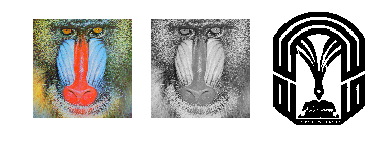

In [25]:
import cv2 #needed for LSBSteg
import docopt #needed for LSBSteg
import numpy as np #needed for LSBSteg
from LSBSteg import LSBSteg 
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from PIL import Image
import matplotlib.pyplot as plt

class dataHidingAttack():
    
    def __init__(self,dataset_path='Dataset\\',results_path='Results\\'):
        self.original_image=''
        self.stego_image=''
        self.secret_text_len=65000
        self.dataset_path=dataset_path
        self.results_path=results_path
    def convert_image_to(self,img,color_type):
        converted_image=img
        if color_type== 'gray':
            converted_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        elif color_type == 'binary':
            ret,converted_image = cv2.threshold(img,180,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
        else:
            print("Unsupported type")
        return converted_image
        
    def hide_logo_in_image(self,logo_file_name,image_file_name):
        lg=cv2.imread(self.dataset_path+logo_file_name)
        img=cv2.imread(self.dataset_path+image_file_name)
        gray_img=self.convert_image_to(img,'gray')
        gray_logo=self.convert_image_to(lg,'gray')
        b_logo=self.convert_image_to(gray_logo,'binary')
        # convert the image from binary 255,0 to binary 1,0
        b_logo[b_logo == 255]=1
        self.showImagesList([img,gray_img, b_logo])
        '''
        data=[22,128,212,120]
        #data1_b="{0:08b}".format(22)
        w=list("0110")
        #mask to clear the LSB
        clr_mask=int("11111110",2)
        #empty container of the watermarked data
        w_data=[0,0,0,0]
        for i in range(len(w)):
            # create the mask to set the w value
            set_mask=int("0000000" + str(w[i]),2)
            # clear and set the w value
            w_data[i]=(data[i] & clr_mask) | set_mask
        #print the resulting data
        print("Original data", data)
        print("Watermarked data", w_data)
        '''
        
    def extract_text_from_txtfile(self,filename,size=0):
        with open(filename,'r') as f:
            if size <= 0:
                return f.read()
            else:
                return f.read(size) 
            
    def showImagesHorizontally(self,list_of_files):
        fig = figure()
        number_of_files = len(list_of_files)
        for i in range(number_of_files):
            a=fig.add_subplot(1,number_of_files,i+1)
            a.title.set_text(str(list_of_files[i]))
            image = cv2.imread(list_of_files[i])
            imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axis('off')
            
    # function to display images horizontally
    def showImagesList(self,list_of_images):
        fig = figure()
        number_of_images = len(list_of_images)
        for i in range(number_of_images):
            a=fig.add_subplot(1,number_of_images,i+1)
            #a.title.set_text(list_of_images[i])
            if len(list_of_images[i].shape) > 2:
                imshow(cv2.cvtColor(list_of_images[i], cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(list_of_images[i],cmap='gray')
            axis('off')
    def show_stego_image(self):
        fig = figure()
        a=fig.add_subplot(1,2,1)
        imshow(cv2.cvtColor(self.original_image, cv2.COLOR_BGR2RGB))
        a.title.set_text("Original Image")
        axis('off')
        a=fig.add_subplot(1,2,2)
        imshow(cv2.cvtColor(self.stego_image, cv2.COLOR_BGR2RGB))
        a.title.set_text("Stego Image")
        axis('off')
        
    # this function is copied from 
    # http://www.xiaoliangbai.com/2016/09/09/more-on-image-noise-generation
    def noise_generator (self,noise_type):
        row,col,ch= self.stego_image.shape
        if noise_type == "gauss":       
            mean = 0.0
            var = 10.99
            sigma = var**0.55
            gauss = np.array(self.stego_image.shape)
            gauss = np.random.normal(mean,sigma,(row,col,ch))
            gauss = gauss.reshape(row,col,ch)
            noisy = self.stego_image + gauss
            return noisy.astype('uint8')
        elif noise_type == "s&p":
            s_vs_p = 0.5
            amount = 0.004
            out = self.stego_image
            # Generate Salt '1' noise
            num_salt = np.ceil(amount * self.stego_image.size * s_vs_p)
            coords = [np.random.randint(0, i - 1, int(num_salt))
                  for i in self.stego_image.shape]
            out[coords] = 255
            # Generate Pepper '0' noise
            num_pepper = np.ceil(amount* self.stego_image.size * (1. - s_vs_p))
            coords = [np.random.randint(0, i - 1, int(num_pepper))
                  for i in self.stego_image.shape]
            out[coords] = 0
            return out.astype('uint8')
        elif noise_type == "poisson":
            vals = len(np.unique(self.stego_image))
            vals = 2 ** np.ceil(np.log2(vals))
            noisy = np.random.poisson(self.stego_image * vals) / float(vals)
            return noisy.astype('uint8')
        elif noise_type =="speckle":
            gauss = np.random.randn(row,col,ch)
            gauss = gauss.reshape(row,col,ch)        
            noisy = self.stego_image + self.stego_image * gauss
            return noisy.astype('unit8')
        else:
            print('error ... unsupported noise type')
            return self.stego_image
        
    def jitter_attack(self,num_cols):
        jittered_img=self.stego_image.copy()
        row,col,ch= jittered_img.shape
        print('original shape',self.stego_image.shape)
        #get the location of the column in the half image position
        jitter_remove_loc=int(col/2)
        # remove 3 columns from the image (remove the 3 columns dividing the image into two right and left parts)
        jittered_img=np.delete(jittered_img,range(jitter_remove_loc,jitter_remove_loc+num_cols),1).copy()
        print('after remove shape',jittered_img.shape)

        jitter_insert_loc=int(0.75*col)
        #insert the same image column num_cols times
        for i in range(num_cols):
            jittered_img=np.insert(jittered_img,jitter_insert_loc,jittered_img[:,jitter_insert_loc],axis=1).copy()
        print('after insert',jittered_img.shape)
        return jittered_img
    
    def hide_text_in_image(self,image_file_name,text_file_name):
        self.original_image=cv2.imread(self.dataset_path+image_file_name)
        steg = LSBSteg(self.original_image)
        #encode stego image (logo)
        img_encoded = steg.encode_text(self.extract_text_from_txtfile(self.dataset_path+text_file_name,self.secret_text_len))
        self.stego_image=img_encoded
        return img_encoded
    def extract_text_from_attacked_image(self,img):
        steg = LSBSteg(img)
        str1=steg.decode_text()
        print('{0:.2f}'.format(len(str1)/self.secret_text_len))
        
    def geom_attack(self,attack_type,value):
        rows,cols,channels = self.stego_image.shape
        if attack_type == 'translate':
            #translating an image 40(value) pixles in x, (value)80 pixels in y
            M = np.float32([[1,0,value*10],[0,1,value*10]])
            translated_image = cv2.warpAffine(self.stego_image,M,(cols,rows))
            return translated_image
        
        elif attack_type == 'rotate':
            R = cv2.getRotationMatrix2D((cols/2,rows/2),value,1) # create rotation matrix
            return cv2.warpAffine(self.stego_image,R,(cols,rows))
        
        elif attack_type == 'scale':
            #value here means how many col/rows are added to the original col/rows
            # -value means subtract it from number of col/rows
            # +value mans adding them to the number of rows
            height, width = self.stego_image.shape[:2]
            res = cv2.resize(self.stego_image,(width+value, height+value), interpolation = cv2.INTER_CUBIC).copy()
            return res
        
        elif attack_type == 'flip':
            #value 1 means horizontal filp, -1 means vertical flip
            flipped_image = cv2.flip(self.stego_image, value )
            return flipped_image
        elif attack_type == 'warp':
            '''
            To find the transformation matrix, we need three points from input
            image and their corresponding locations in output image.
            Then cv2.getAffineTransform will create a 2x3 matrix
            which is to be passed to cv2.warpAffine.
            '''
            #typical value = 5
            pts1 = np.float32([[value*10,value*10],[value*40,value*10],[value*10,value*40]])
            pts2 = np.float32([[value*2,value*20],[value*40,value*10],[value*20,value*50]])
            M = cv2.getAffineTransform(pts1,pts2)
            warped_image = cv2.warpAffine(self.stego_image,M,(cols,rows))
            return warped_image
        elif attack_type == 'perspective':
            '''
            For perspective transformation, you need a 3x3 transformation matrix.
            Straight lines will remain straight even after the transformation.
            To find this transformation matrix, you need 4 points on the input 
            image and corresponding points on the output image. Among these 4 points,
            3 of them should not be collinear. Then transformation matrix can be found
            by the function cv2.getPerspectiveTransform. Then apply cv2.warpPerspective 
            with this 3x3 transformation matrix.
            '''
            pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
            pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])

            M = cv2.getPerspectiveTransform(pts1,pts2)
            perspective_image = cv2.warpPerspective(self.stego_image,M,(430,400))
            return perspective_image
        elif attack_type == 'crop':
            cropped_image = self.stego_image[:value, :value]
            return cropped_image
        elif attack_type == 'linear_transform':
            R = cv2.getRotationMatrix2D((cols/2,rows/2),value,1) # create rotation matrix
            R=np.append(R,[[0,0,1]],axis=0) # add last row as indication of homogenous coordinates
            #print('R=',R)
            S = np.float32([[0.7, 0, 0],[0, 0.7, 0]]) # Scale matrix
            S=np.append(S,[[0,0,1]],axis=0)
            #print('S=',S)
            Sh = np.float32([[1, 0, 0],[1.5, 1, 0]]) # Shear matrix
            Sh=np.append(Sh,[[0,0,1]],axis=0)
            #print('Sh=',Sh)
            K=R.dot(S).dot(Sh) #linear combination of matrices, changing the order with change the result
            K=np.delete(K,2,axis=0) # delete the last row as it is not needed in cv transform
            #print("R*S*Sh=",K)
            lineartransed_image = cv2.warpAffine(self.stego_image,K,(cols,rows))
            return lineartransed_image
        else:
            print('error ... unsupported geometric attack')
    def stir_mark(self,attack_value):
        # we focus only on the following sequence of transformations
        #rotates, translate, shear, crop and resize

        return 0
            
# this must be run everytime we open the notebook, other parts of the notebook can be ignored
myHideObj=dataHidingAttack()
stego_image=myHideObj.hide_text_in_image('Baboon.tiff','secret_text.txt') 
myHideObj.hide_logo_in_image('logo.tif','Baboon.tiff')

geoAttackObj=dataHidingAttack()
stego_image=geoAttackObj.hide_text_in_image('Pepper.tiff','secret_text.txt') 

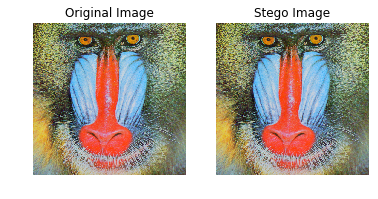

In [20]:
myHideObj.show_stego_image()

## 1. Geometric Transforms

### 1.1 Translation

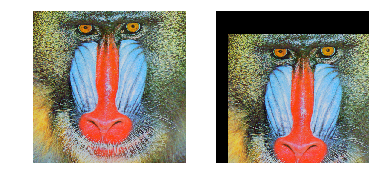

In [24]:
t_img=myHideObj.geom_attack('translate')
myHideObj.showImagesList([myHideObj.stego_image,t_img])


### 1.2 Flipping

0.13


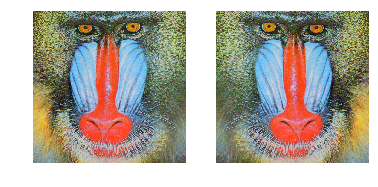

In [20]:
#M = cv2.getRotationMatrix2D((cols/2,rows/2),180,1)
t_img=myHideObj.geom_attack('flip')
myHideObj.showImagesList([myHideObj.stego_image,t_img])
myHideObj.extract_text_from_attacked_image(t_img)

### 1.3 Warping

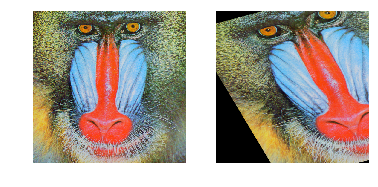

In [31]:
t_img=myHideObj.geom_attack('warp')
myHideObj.showImagesList([myHideObj.stego_image,t_img])

### 1.4 Perspective

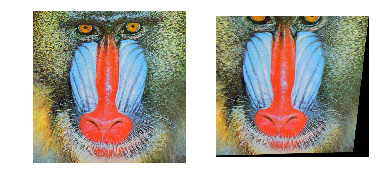

In [33]:
t_img=myHideObj.geom_attack('perspective')
myHideObj.showImagesList([myHideObj.stego_image,t_img])

### 1.5 Cropping

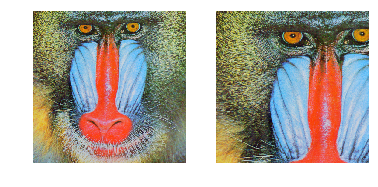

In [35]:
t_img=myHideObj.geom_attack('crop')
myHideObj.showImagesList([myHideObj.stego_image,t_img])

### 1.6 Linear transform

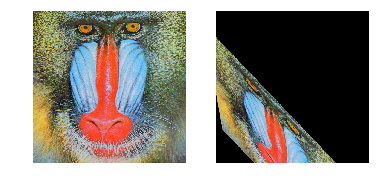

In [7]:
t_img=myHideObj.geom_attack('linear_transform')
myHideObj.showImagesList([myHideObj.stego_image,t_img])

### 1.7 Rotate

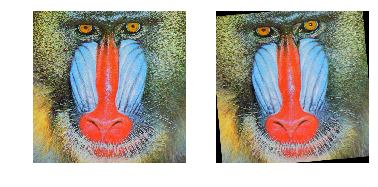

In [11]:
t_img=myHideObj.geom_attack('rotate')
myHideObj.showImagesList([myHideObj.stego_image,t_img])


### 1.8 scale 

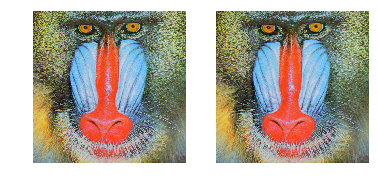

In [50]:
t_img=myHideObj.geom_attack('scale',20)
myHideObj.showImagesList([myHideObj.stego_image,t_img])

## 2. Image Degradation Attacks

### 2.1 Noise Addition

0.09


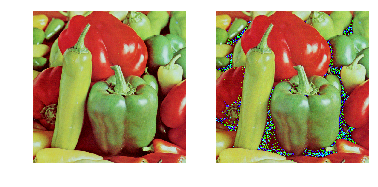

In [33]:
t_img=geoAttackObj.noise_generator('gauss')
geoAttackObj.showImagesList([geoAttackObj.stego_image,t_img])
geoAttackObj.extract_text_from_attacked_image(t_img)

### 2.2 Jitter attack

original shape (512, 512, 3)
after remove shape (512, 462, 3)
after insert (512, 512, 3)


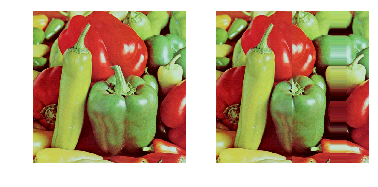

In [42]:
t_img=geoAttackObj.jitter_attack(50)
geoAttackObj.showImagesList([geoAttackObj.stego_image,t_img])

## References: 

1. Geometric Attacks
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html#py-table-of-content-imgproc
2. Noise Addition
https://blog.kyleingraham.com/2017/02/04/salt-pepper-noise-and-median-filters-part-ii-the-code/
3. More on adding noise
http://www.xiaoliangbai.com/2016/09/09/more-on-image-noise-generation
4. OpenCV-Python Tutorials Documentation https://media.readthedocs.org/pdf/opencv-python-tutroals/latest/opencv-python-tutroals.pdf
